In [320]:
import numpy as np
import matplotlib.pyplot as plt

### Multiklass-klassificering 

Detta är ett första test för multiklass-klassificering. Data genereras med vägledning från https://machinelearningmastery.com/generate-test-datasets-python-scikit-learn/

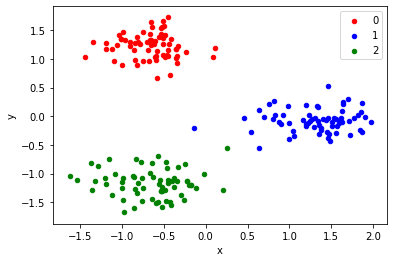

In [321]:
from sklearn.datasets import make_blobs
from pandas import DataFrame
# generate 2d (linear) classification dataset
N = 200
X, y = make_blobs(n_samples=N, centers=3, n_features=2)
#rescale x-values?
X[:,0] = (X[:,0]-np.mean(X[:,0]))/np.std(X[:,0])
X[:,1] = (X[:,1]-np.mean(X[:,1]))/np.std(X[:,1])
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

Vi försöker lösa detta problem genom att lösa tre separata binära klassificeringsproblem enligt "One-vs-all", där varje delproblem löses med logistisk regression. Dvs, vi tränar tre funktioner $f_w^i$ där $i=1,2,3$ där vi för varje klass i predikterar sannolikheten att $y=i$. För en ny input x görs en prediktion genom att beräkna $\max_i f_w^i(x)$.

För varje utvald klass har vi liksom modellen 
$$f_{\omega_0,\omega_1,\omega_2}(x_1,x_2) = P(Y = 1|x,\vec{\omega}) = \frac{1}{1+e^{-(\omega_0 + \omega_1 x_1 + \omega_2 x_2)}} = \frac{e^{(\omega_0 + \omega_1 x_1 + \omega_2 x_2)}}{1+e^{(\omega_0 + \omega_1 x_1 + \omega_2 x_2)}}$$
Och loss funktionen
$$L(f_{\omega_0,\omega_1,\omega_2}(x_1,x_2),y) = -y\log(f_{\omega_0,\omega_1,\omega_2}(x_1,x_2)) - (1-y)\log(1-f_{\omega_0,\omega_1,\omega_2}(x_1,x_2))$$
Så lossen för all våran data är
$$L = -\sum_{i=0}^N y^i\log(f_{\omega_0,\omega_1,\omega_2}(x^i_1,x^i_2)) + (1-y^i)\log(1-f_{\omega_0,\omega_1,\omega_2}(x^i_1,x^i_2))$$
Det är den här lossen vi vill minimera med någon metod. Alltså hitta de optimala parametrarna $\omega_0,\omega_1,\omega_2$

In [322]:
def f(x,w):
    """Output of the neural network, where w is the 3D vector containing the weights and x1 and x2 are the 
    input coordinates. Outputs a value in the range [0,1]. """
    a = w[0]+w[1]*x[0]+w[2]*x[1]
    return 1/(1+np.exp(-a))

In [323]:
def loss(x,w,y):
    #log-loss or binary cross-entropy is used
    #Returns value -y*np.log(f(x1,x2,w))-(1-y)*np.log(1-f(x1,x2,w))
    if y == 1:
        return -np.log(f(x,w))
    else:
        return -np.log(1-f(x,w))

In [324]:
def total_loss(x,w,y):
    #This is the total log-loss from all training data.
    L = 0
    for i in range(N):
        L += loss(x[i,:],w,y[i])
    return L/N
    

Använder kedjeregeln så att vi kan utnyttja att $\frac{\partial L}{\partial w_i} = \frac{\partial L}{\partial f}\frac{\partial f}{\partial a}\frac{\partial a}{\partial w_i}$

In [325]:
def gradient_sample(w,x,y):
    #Computes the gradient with respect to one sample only by using backpropagation (the chain rule)
    
    #xvec = np.array([1,x[0],x[1]])
    #return xvec*(-y+1/(1+np.exp(w@xvec))) #Division by zero in log if this is used
    
    a = w[0]+w[1]*x[0]+w[2]*x[1];
    dfda = np.exp(-a)/((1+np.exp(-a))**2)
    
    dadw = np.array([1,x[0],x[1]])
    if y ==1:
        return -dfda*dadw/f(x,w)
    else:
        return dfda*dadw/(1-f(x,w))
    


In [326]:
def gradient(w,x = X,y=y):
    #Computes total gradient 
    g = 0
    for i in range(N):
        g = g+gradient_sample(w,x[i,:],y[i])
    return g

In [327]:
def train(y,train_sessions,x =X,N =N,SGD=1,alpha = 0.1):
    w = np.random.normal(size = (3,))
    E = []

    for i in range(train_sessions):
        #If training with gradient descent
        if not SGD:
            w = w-alpha*gradient(w,x,y)
        else:    
            #If training with SGD - can I choose the same sample multiple times?
            k = np.random.randint(0,N)
            w = w-alpha*gradient_sample(w,x[k,:],y[k])

        if i%N == 0:
            E.append(total_loss(x,w,y))
    return w,E

Här vill vi nu träna tre olika nätverk

In [328]:
train_sessions = 20000
ytemp = y.copy()

for i in range(N):
    if y[i] == 2:
        ytemp[i] =1
    elif y[i] == 1:
        ytemp[i] = 0
w1,E1 = train(ytemp,train_sessions,SGD = 1)

ytemp = y.copy()
for i in range(N):
    if y[i] == 2:
        ytemp[i] =0
w2,E2 = train(ytemp,train_sessions,SGD = 1)

ytemp = y.copy()
for i in range(N):
    if y[i] == 2:
        ytemp[i] =1
w3,E3 = train(ytemp,train_sessions,SGD = 1)

print(w1,w2,w3)


[-3.02363831 -4.13673375 -7.72746612] [-2.5517607   8.43946627  0.39007991] [ 3.17749409  3.5584041  -7.43789092]


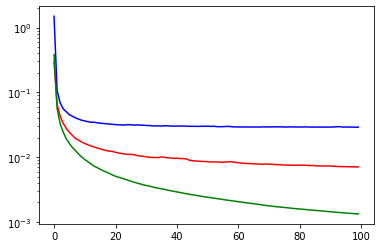

In [329]:
plt.figure()
plt.semilogy(E1,'r')
plt.semilogy(E2,'b')
plt.semilogy(E3,'g')


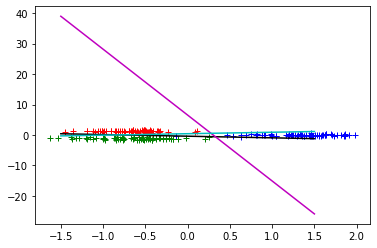

In [330]:
plt.figure()
plt.plot(X[y==0,0],X[y==0,1],'r+') #plots all points with albels 0
plt.plot(X[y==1,0],X[y==1,1],'b+') #plots all points with labels 1
plt.plot(X[y==2,0],X[y==2,1],'g+') #plots all points with labels 2
XX = np.linspace(-1.5,1.5)
plt.plot(XX,-w1[0]/w1[2]-(w1[1]/w1[2])*XX,'k') #plots the trained hyperplane 1
plt.plot(XX,-w2[0]/w2[2]-(w2[1]/w2[2])*XX,'m') #plots the trained hyperplane 2
plt.plot(XX,-w3[0]/w3[2]-(w3[1]/w3[2])*XX,'c') #plots the trained hyperplane 3

#plt.plot([0,-w1[0]/w1[1]],[-w1[0]/w1[2],0],'k') 
#plt.plot([0,-w2[0]/w2[1]],[-w2[0]/w2[2],0],'m') 
#plt.plot([0,-w3[0]/w3[1]],[-w3[0]/w3[2],0],'c') 

### Testdata

Vi testar nu att generera ny data och försöker klassificera denna med hjälp av de tre nätverken.

In [331]:
np.random.seed(133)
M = 50 #number of data points
x_test = np.random.uniform(-1.5,1.5, size = (M,2))

[0.9999841417625064, 2.1172049574769155e-06, 0.9995672018941896]
[0.9991568423695897, 0.0180017385612614, 0.9999941044806555]
[0.99958805333742, 0.000516153930728042, 0.999924725125793]
[0.0009211150071921109, 0.9997541889409427, 0.9998914817195771]
[0.9904665071988804, 0.0004771359640063688, 0.9980612440620978]
[1.2382743916526935e-05, 0.999997978975707, 0.9998968151041672]
[0.00033683508411720534, 5.437729538793781e-06, 2.4778367623576694e-05]
[2.522148728298733e-05, 0.001678884047477983, 0.0003464784244295028]
[1.977503009771528e-06, 0.002049870812531599, 3.191763147708101e-05]
[0.9999189076072009, 1.1813414264194524e-05, 0.9995352027214831]
[0.9999964014187661, 4.726522541196729e-07, 0.9996170740593106]
[0.9999066115471772, 0.0005410400848565654, 0.9999838716277205]
[0.0002998665818657681, 0.0007515110651243391, 0.002011373518846188]
[0.0001419708900014861, 0.9999975734565032, 0.9999895845218637]
[0.9989921341694218, 0.0021304702900550613, 0.9999493933633876]
[0.001507289724327854,

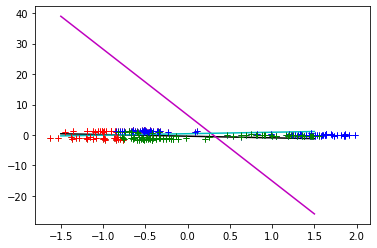

In [332]:
plt.figure()
plt.plot(X[y==0,0],X[y==0,1],'r+') #plots all points with albels 0
plt.plot(X[y==1,0],X[y==1,1],'b+') #plots all points with labels 1
plt.plot(X[y==2,0],X[y==2,1],'g+') #plots all points with labels 2

plt.plot(XX,-w1[0]/w1[2]-(w1[1]/w1[2])*XX,'k') #plots the trained hyperplane 1
plt.plot(XX,-w2[0]/w2[2]-(w2[1]/w2[2])*XX,'m') #plots the trained hyperplane 2
plt.plot(XX,-w3[0]/w3[2]-(w3[1]/w3[2])*XX,'c') #plots the trained hyperplane 3

w = [w1,w2,w3]
test = 0

if test:
    y_test = np.zeros(shape = (M,))

    for i in range(M):
        res = [0,0,0]
        for k in range(3):
            res[k] = f(x_test[i],w[k])
        #print(res)
        j = np.argmax(res) #Vi predikterar att träningsdata tillhör den klass för vilken f_w^i antar störst värde
        y_test[i] = j

    #print(y_test)
    plt.plot(x_test[y_test==0,0],x_test[y_test==0,1],'ro') #plots all points with albels 0
    plt.plot(x_test[y_test==1,0],x_test[y_test==1,1],'bo') #plots all points with labels 1
    plt.plot(x_test[y_test==2,0],x_test[y_test==2,1],'go') #plots all points with labels 2
else:
    #Predikterar med hjälp av max även för träningsdatan
    y_train = np.zeros(shape = (N,))
    for i in range(N):
        res = [0,0,0]
        for k in range(3):
            res[k] = f(X[i],w[k])
        print(res)
        j = np.argmax(res) #Vi predikterar att träningsdata tillhör den klass för vilken f_w^i antar störst värde
        y_train[i] = j
    plt.plot(X[y_train==0,0],X[y_train==0,1],'r+') #plots all points with albels 0
    plt.plot(X[y_train==1,0],X[y_train==1,1],'b+') #plots all points with labels 1
    plt.plot(X[y_train==2,0],X[y_train==2,1],'g+') #plots all points with labels 2

    